# Analysis of Control Tumour Growth

This notebook aims at reproducing the control tumour growth PD model reported in [[1](ref)]. The model is a part of a larger translational PKPD study that predicted tumour stasis inducing dosing strategies from mouse data for humans. The present study investigates the reproducibility and reliablility of the reported modelling results.

The structural and error part of the tumour growth PD model are well documented in [[1](ref)], while the population model and inference approach is less well defined. As a result, we will adopt the specified structural model and error model, and use a principled Bayesian workflow inspired by [[2](ref2)] to build a population model and inference scheme.

Bibliography:

- <a name="ref"> [1] </a> Eigenmann et. al., Combining Nonclinical Experiments with Translational PKPD Modeling to Differentiate Erlotinib and Gefitinib, Mol Cancer Ther (2016)
- <a name="ref2"> [2] </a> Betancourt, https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html (April 2020), last visited: 14/06/2020
- <a name="ref3"> [3] </a> Koch et. al., Modeling of tumor growth and anticancer effects of combination therapy, Journal of Pharmacokinetics and Pharmacokinetics, (2009)

## 1. Available data

In [[1](ref)], the tumour growth inhibition (TGI) PKPD model of Erlotinib and Gefitinib was derived from three separate *in vivo* experiments. In partcular, patient-derived tumour explants LXF A677 (adenocarcinoma of the lung) and cell line-derived tumour xenografts VXF A431 (vulva cancer) were subcutaneously implanted in mice. Each experiment comprised a control group and six groups treated with either Erlotinib or Gefitnib at one of three dose levels each. Treatments were orally administered once a day.

The inverstigation of the full TGI PKPD model is subject of other notebooks. Here, we focus on establishing a good understanding of the growth part of the PD model. This allows us to get a better idea of the feasibility of the modelling choice. It further allows to derive posteriors for the growth parameters, that may inform the choice of priors for the full TGI-PKPD model inference.

We will now import the data sets. According to [[2](ref)], we are not supposed to look at the data prior to building the PKPD model and especially not inform our choice of prior distributions of the parameters by it. This leads to an artificial tuning of the priors to make the prior predictive model more closely represent the data. As a result, the data would be used twice to construct the posterior predictive model which inevitably will bias the modelling results. We will therefore retract from visualising the data and just check that the import of the data was successful by looking at the data in tabular form.

In [16]:
#
# Import raw LXF A677 data.
#
import os
import pandas as pd

# Import LXF A677 data
path = os.getcwd()  # to make import independent of local path structure
lxf_data_raw = pd.read_csv(path + '/data/Ctrl_Growth_LXF.csv')

# Display data
print('Raw LXF A677 Control Growth Data Set:')
lxf_data_raw

LXF A677 Control Growth:


,#ID,TIME,DOSE,ADDL,II,Y,YTYPE,CENS,CELL LINE,DOSE GROUP,DRUG,DRUGCAT,EXPERIMENT,BW,YTV,KA,V,KE,w0
0,40,0,.,.,.,191.808,2,.,1,0,2,0,2,26.8,.,55,1.11,3.98,191.8080
1,94,0,.,.,.,77.2475,2,.,1,0,2,0,2,18.3,.,55,1.11,3.98,77.2475
2,95,0,.,.,.,186.2,2,.,1,0,2,0,2,22.3,.,55,1.11,3.98,186.2000
3,40,3,0,.,.,.,.,.,1,0,2,0,2,26.1,.,55,1.11,3.98,191.8080
4,40,4,0,2,1,.,.,.,1,0,2,0,2,26.5,.,55,1.11,3.98,191.8080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,140,2,.,.,.,126.852,2,.,1,0,2,0,2,23.6,126.852,55,1.11,3.98,79.3305
154,94,4,.,.,.,125.316,2,.,1,0,2,0,2,18.5,125.316,55,1.11,3.98,77.2475
155,170,4,.,.,.,109.33,2,.,1,0,2,0,2,27.9,109.33,55,1.11,3.98,80.0565
156,170,2,.,.,.,94.221,2,.,1,0,2,0,2,27.7,94.221,55,1.11,3.98,80.0565


In [18]:
#
# Import raw VXF A341 data.
#
import os
import pandas as pd

# Import VXF A341 data
path = os.getcwd()  # to make import independent of local path structure
vxf_data_raw = pd.read_csv(path + '/data/Ctrl_Growth_VXF.csv', sep=';')

# Display data
print('Raw VXF A341 Control Growth data set:')
vxf_data_raw

VXF A341 Control Growth:


,#ID,MICE,TIME,DOSE,ADDL,II,TUMOR,YTV,w0
0,1,708,0,.,.,.,92.5,.,92.5
1,1,708,3,.,.,.,115.2,115.2,92.5
2,1,708,3,0,3,1,.,.,92.5
3,1,708,7,.,.,.,133.2,134.2,92.5
4,1,708,7,0,2,1,.,.,92.5
...,...,...,...,...,...,...,...,...,...
128,7,743,30,.,.,.,1304.6875,1304.6875,207.4
129,7,743,32,.,.,.,1419.6,1419.6,207.4
130,7,743,35,.,.,.,1530.9,1530.9,207.4
131,7,743,37,.,.,.,1576.4625,1576.4625,207.4


Note how the first data set seems to contain a lot more information than the second one. However, there is a lot of information that is not relevant for us. These data sets were manipulated with Monolix. That is why the meaning of most column keys can be looked up in the Monolix documentation. However, there are some customised keys whose meaning is not immediately clear. 

All we really need for our analyis is

- **#ID** indicating the mouse the measurements belong to
- **TIME** indicating the time point of each measurement
- **VOLUME** indicating the measured tumour volume.

While the columns **#ID** and **TIME** are easy to idenitfy in the data sets, **VOLUME** was intentionally chosen to not be one of the existing column keys. In both data sets there exist two keys that may potentially encode for the measured tumour volumes: **Y** and **YTV** in LXF; and **TUMOR** and **YTV** in VXF. The true measurements of the first experiment are easily identified by looking into the Monolix documentation. **Y** is here generally used as an identifier for the observations. For the second table it seems less obvious which column might contain the true data. However, in analogy with the first data set one might suspect that YTV is not the actual data. So until this will be clarified at a later stage, we will choose to use TUMOR as the true data.

Remarks on remaining column keys:

- **DOSE**: Seems to be a customised key encoding for the applied dose. This is the control group so we should ensure that this column has only NaN or zero entries.
- **ADDL**, **II**: According to Monolix these keys encode for the number of doses (ADDL) to add in addition to the dose in intervals specified by II. Since this is supposed to be the control group, we should filter out any rows with non-null values for these keys.
- **YTYPE**, **CENS**: According to Monolix these keys encode for the data type (tumour volume in this case) and whether the measurered values were subject to censoring. We should make sure that censored data should be dealt with accordingly and only one data type is present in the data set.
- **CELL LINE**, **DOSE GROUP**, **DRUG**, **EXPERIMENT**: These customised keys are quite self-explanatory. We should make sure that the data we use is uni-valued in these columns.
- **DRUGCAT**: The meaning of this key is less clear. It may refer to the drug category encoding for the route of administration. We should make sure that this column is also only uni-valued. If mutliple values are assumed we need to clarify what this column means.
- **BW**: refers to the body weight of the mouse at the time of the measurement.
- **KA**, **V**, **KE**, **w0**: These keys are customised key, whose meaning is not immediately clear. They appear to be parameters of the PKPD model. We are interested in infering parameters, so we are not interested in any previously obtained parameters, and choose to ignore this column.

Remarks on units of relevant columns:

The raw data sets do not contain the units of the measured quantities. From the reference [[1](ref)], we may however infer that 
- **TIME**: was measured in days, and
- **TUMOUR VOLUME**: was measured in mm$^3$. 

In [52]:
#
# Create LXF A677 data from raw data set.
#
import os
import pandas as pd

# Import LXF A677 data
path = os.getcwd()  # to make import independent of local path structure
lxf_data_raw = pd.read_csv(path + '/data/Ctrl_Growth_LXF.csv')

# Make sure that data is stored as numeric data
lxf_data = lxf_data_raw.apply(pd.to_numeric, errors='coerce')

# Mask data for non-null Y rows
lxf_data = lxf_data[lxf_data['Y'].notnull()]

# Rename Y to TUMOUR VOLUME in mm^3
lxf_data = lxf_data.rename(columns={'Y': 'TUMOUR VOLUME in mm^3'})

# Rename TIME to TIME in day
lxf_data = lxf_data.rename(columns={'TIME': 'TIME in day'})

# Raise error if DOSE, ADDL, II, YTYPE, CENS, CELL LINE, DOSE GROUP, DRUG, EXPERIMENT or DRUGCAT are not uni-valued
if len(lxf_data['DOSE'].unique()) > 1:
    raise ValueError
if len(lxf_data['ADDL'].unique()) > 1:
    raise ValueError
if len(lxf_data['II'].unique()) > 1:
    raise ValueError
if len(lxf_data['YTYPE'].unique()) > 1:
    raise ValueError
if len(lxf_data['CENS'].unique()) > 1:
    raise ValueError
if len(lxf_data['CELL LINE'].unique()) > 1:
    raise ValueError
if len(lxf_data['DOSE GROUP'].unique()) > 1:
    raise ValueError
if len(lxf_data['DRUG'].unique()) > 1:
    raise ValueError
if len(lxf_data['EXPERIMENT'].unique()) > 1:
    raise ValueError
if len(lxf_data['DRUGCAT'].unique()) > 1:
    raise ValueError

# Keep only #ID, TIME and TUMOUR VOLUME column
lxf_data = lxf_data[['#ID', 'TIME in day', 'TUMOUR VOLUME in mm^3']]

# Delete raw data from memory
del lxf_data_raw

# Display cleaned data set
print('LXF A677 Control Growth:')
lxf_data

LXF A677 Control Growth:


,#ID,TIME in day,TUMOUR VOLUME in mm^3
0,40,0,191.8080
1,94,0,77.2475
2,95,0,186.2000
59,136,0,118.5885
60,140,0,79.3305
...,...,...,...
153,140,2,126.8520
154,94,4,125.3160
155,170,4,109.3300
156,170,2,94.2210


In [54]:
#
# Create VXF A341 data from raw data set.
#
import os
import pandas as pd

# Import LXF A677 data
path = os.getcwd()  # to make import independent of local path structure
vxf_data_raw = pd.read_csv(path + '/data/Ctrl_Growth_VXF.csv', sep=';')

# Make sure that data is stored as numeric data
vxf_data = vxf_data_raw.apply(pd.to_numeric, errors='coerce')

# Mask data for rows where TUMOR and YTV coincide
vxf_data = vxf_data[vxf_data['TUMOR'].notnull()]

# Rename TUMOR to TUMOUR VOLUME in mm^3
vxf_data = vxf_data.rename(columns={'TUMOR': 'TUMOUR VOLUME in mm^3'})

# Rename TIME to TIME in day
vxf_data = vxf_data.rename(columns={'TIME': 'TIME in day'})

# Raise error if DOSE, ADDL or II are not uni-valued
if len(vxf_data['DOSE'].unique()) > 1:
    raise ValueError
if len(vxf_data['ADDL'].unique()) > 1:
    raise ValueError
if len(vxf_data['II'].unique()) > 1:
    raise ValueError

# Keep only #ID, TIME and TUMOUR VOLUME column
vxf_data = vxf_data[['#ID', 'TIME in day', 'TUMOUR VOLUME in mm^3']]

# Delete raw data from memory
del vxf_data_raw

# Display cleaned data set
print('VXF A341 Control Growth:')
vxf_data

VXF A341 Control Growth:


,#ID,TIME in day,TUMOUR VOLUME in mm^3
0,1,0,92.5000
1,1,3,115.2000
3,1,7,133.2000
5,1,10,136.8000
7,1,14,233.2800
...,...,...,...
128,7,30,1304.6875
129,7,32,1419.6000
130,7,35,1530.9000
131,7,37,1576.4625


## 2. PKPD Model Structure

In [[1](ref)] the tumour growth is modelled by 

\begin{align}
\frac{\text{d}V_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V_T}{2\lambda _0 V_T + \lambda _1} - \kappa CV_T,
\end{align}

where
- $V_T$ is the tumour volume in $[$mm$^3]$, 
- $\lambda_0$ is the exponential growth rate of the tumour in $[$1/day$]$, 
- $\lambda_1$ is the linear growth rate of the tumour in $[$mm$^3$/day$]$ and
- $\kappa $ is the potency of drug in $[$L/mg/day$]$.

In absence of the drug, this expression reduces to
 
\begin{align}
\frac{\text{d}V_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V_T}{2\lambda _0 V_T + \lambda _1}.
\end{align}

Although not all assumptions are explicitly stated in the reference [[1](ref)], the PD model makes a number of them to describe the tumour growth. The most obvious assumption of the model is a transition of the tumour growth from an exponential growth to a linear growth at a characteristic tumour volume

\begin{align}
V^c_T = \frac{\lambda_1}{2\lambda _0}.
\end{align}

For $V_T<<V^c_T$ the tumour is modelled by an exponential growth, while for $V_T>>V^c_T$ the tumour growth is linear. This tumour growth model was first introduced in [[3](ref3)], and builds on the intuition that in the early stages of the tumour an abundance of oxygen and nutrients leads to a constant doubling time of cancerous cells, and therefore to an exponential growth. However, in later stages of the tumour growth oxygen and other sources of nutrition are being depleted inside the tumour, and only the 'shell' tumour cells are able to proliferate at the inital rate. While there are ways for the tumour mass to expand in the inside too, by changing the mode of metabolism to glycolysis or rewiring of the blood vessels to improve the oxygen supply, it is clear that the growth rate should be expected to slow down. Due to the complexity of the process it is not obvious that the growth should be expected to change qualitatively from exponential to linear. However, in [[3](ref3)] it was argued that a linear growth phase was observed for later stages of tumour evolution in experiments. By investigating the estimate for $V^c_T$ we will be able to assess this modelling choice directly. 

Furthermore, it is intuitively clear that the validity of the model cannot hold for all values of $V_T\in \mathbb{R}$. For small tumour sizes, where the tumour may only consist of a small number of cancerous cells surrounded by a tissue of healthy cells, it is no longer appropriate to assume a deterministic proliferation rate. A stochastic model incorporating drift, and in particular a finite probablity of extinction may be more appropriate. A second assumption of a constant growth rate of the tumour also assumes that no cancerous mutations with a selective advantage are permitted to appear. This assumption may also only be valid when the tumour has been exposed to a serious of aspative processes, such that better mutants may be unlikely to occur. Both these arguments suggest that the above model should have a lower limit, where the model loses validity. It is not clear what this limit should be exactly, but we may set it somewhat conservatively to $1 \, \text{mm}^3$. Similarly, with an average volume of a mouse of the order of $1\, \text{dm}^3$, it may be expected that the growth behaviour of the tumour will significantly change at the lates for values of about $10^6\text{mm}^3$. We shall thereofer limit the applicability of our model to the regime 

\begin{align}
V_T\in [10^{-3}, 10^3] \, \text{cm}^3.
\end{align}

As a result, we will deviate from the unit choice in [[1](ref)] and choose to parameterise the model parameters by
- $V_T$ is the tumour volume in $[$cm$^3]$, 
- $\lambda_0$ is the exponential growth rate of the tumour in $[$1/day$]$, 
- $\lambda_1$ is the linear growth rate of the tumour in $[$cm$^3$/day$]$ and
- $\kappa $ is the potency of drug in $[$L/mg/day$]$.

In [[1](ref)] the structural model parameters $\lambda_0$, $\lambda_1$, as well as the initial tumour volume $V_{T,0}$ are expected to vary between individuals. For notational ease we will define 

\begin{align}
\psi = (\lambda_0, \lambda_1, V_{T,0}).
\end{align}

The so called population model of how the parameters $\psi$ vary across indiviudals was, however, not clearly specified. We will therefore choose to model the population by independent lognormal distributions, i.e. the logarithms of the parameters $\psi $ are normally distributed

\begin{align}
\log \psi \sim \mathcal{N}(\overline{\log \psi}, \Sigma ),
\end{align}

where $\overline{\log \psi} = (\overline{\log \lambda_0}, \overline{\log \lambda_1}, \overline{\log V_{T,0}})$ is the population mean of $\log \psi$, and $\Sigma = \text{diag}(\sigma ^2_{0}, \sigma ^2_{1}, \sigma ^2_{V})$ the covariance in the population. This is a natural first choice for the population distribution, because all structural model parameters are semi-positive definite, $\psi \geq 0$. To assume that there is no correlation between the inital tumour volume $V_{T,0}$ and the growth parameters $\lambda_0, \lambda_1$ is a strong assumption, especially since one might expect that a particularly large initial tumour volume may indicate an alleviated tumour growth. However, we will at start off with this assumption in analogy to the reference [[1](ref)], and later critically assess it.

The predictions of the structural model for each indiviudal $V_T$ were assumed to deviate from the observations $V^{\text{obs}}_T$ according to an error model specified by 

\begin{align}
V^{\text{pred}}_T = V_T + (a + b V_T)\varepsilon ,
\end{align}

where $a$ and $b$ are constants and $\varepsilon $ is a standard Gaussian random variable, $\varepsilon \sim \mathcal{N}(0, 1)$. $V^{\text{pred}}_T$ emulates the behaviour of future measurements and incorporates their randomness due to measurement error and subtle processes that may not be captured by the structural model. Intuitively the combined error model is a mixture of a constand Gaussian noise that formalises the expectation of a base level noise, and a heteroscedastic noise which assumes that the error will grow relative to the predicted volume. At this point also the error model remains an assumption that remains to be critically assessed by the end of the analysis.

So far we have been largely guided by the reference [[1](ref)]. What remains to be done before we can use Bayesian inference to learn the posterior predictive model from the observations is to specify our prior belief in the parameter distirbutions and check that this leads to a prior predicitve model that agrees with our understanding of the biology. One further thing that may be considered good practice from a modelling perspective is to clearly define the realm in which the predictions of our model may be considered trustworthy.

## 2. Visualise observed tumour growth

In [ ]:
# Filter relevant information
data = data_raw[['#ID', 'TIME', 'Y']]

# Convert TIME and Y to numeric values (currently strings)
data['TIME'] = pd.to_numeric(data['TIME'], errors='coerce')
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

# Sort TIME values (for plotting convenience)
data.sort_values(by='TIME', inplace=True)

# Show data
data

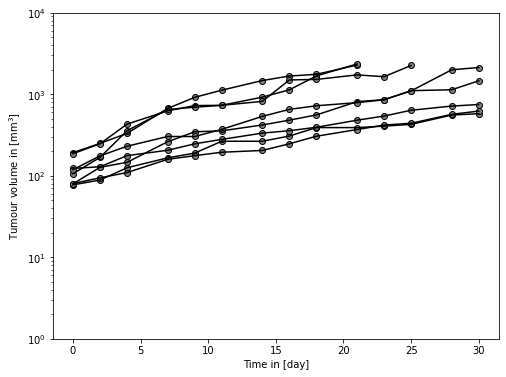

In [4]:
import matplotlib.pyplot as plt

# Get unique animal IDs
ids = data['#ID'].unique()

# Plot measurements
fig = plt.figure(figsize=(8, 6))

for i in ids:
    # Mask for individual
    mask = data['#ID'] == i
    time = data[mask]['TIME']
    volume = data[mask]['Y']

    # Filter out Nan values
    mask = volume.notnull()
    time = time[mask]
    volume = volume[mask]

    # Create semi log plot
    plt.semilogy(time, volume, color='black')
    plt.scatter(time, volume, color='gray', edgecolor='black')

# Set y limits (to be consistent with predictions in other notebooks)
plt.ylim([1E0, 1E4])

# Label axes
plt.xlabel('Time in [day]')
plt.ylabel(r'Tumour volume in [mm$^3$]')

plt.show()

## 3. Infer growth parameters

In [[1](ref)] the tumour growth is modelled by 

\begin{align}
\frac{\text{d}V_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V_T}{2\lambda _0 V_T + \lambda _1} - \kappa CV_T,
\end{align}

where
- $V_T$ the tumour volume in $[$mm$^3]$, 
- $\lambda_0$ the exponential growth rate of the tumour in $[$1/day$]$, 
- $\lambda_1$ the linear growth rate of the tumour in $[$mm$^3$/day$]$ and
- $\kappa $ the potency of drug in $[$L/mg/day$]$.

In absence of the drug, this expression reduces to 
\begin{align}
\frac{\text{d}V_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V_T}{2\lambda _0 V_T + \lambda _1}.
\end{align}

In [[1](ref)] the structural model parameters $\lambda_0$, $\lambda_1$, as well as the initial tumour volume $V_{T,0}$ are expected to vary between individuals. For notational ease we will define 

\begin{align}
\psi = (\lambda_0, \lambda_1, V_{T,0}).
\end{align}

The so called population model of how the parameters $\psi$ vary across indiviudals was, however, not clearly specified in [[1](ref)]. We will therefore choose to model the population by independent lognormal distributions, i.e. the logarithms of the parameters $\psi $ are normally distributed

\begin{align}
\log \psi = \mathcal{N}(\overline{\log \psi}, \Sigma ),
\end{align}

where $\overline{\log \psi} = (\overline{\log \lambda_0}, \overline{\log \lambda_1}, \overline{\log V_{T,0}})$ is the population mean of $\log \psi$, and $\Sigma = \text{diag}(\sigma ^2_{0}, \sigma ^2_{1}, \sigma ^2_{V})$ the covariance in the population. This is a natural first choice for the population distribution, because all structural model parameters are semi positive definite, $\psi \geq 0$.

In [ ]:
import myokit

from pkpd import model as m

# Build tumor growth inhibition model with default parameters
model = m.create_pktgi_model()import myokit

from pkpd import model as m

# Build tumor growth inhibition model with default parameters
model = m.create_pktgi_model()